In [ ]:
from qiskit import QuantumCircuit, execute, Aer, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit.quantum_info.operators import Operator
from cmath import exp
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit.library import QFT
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
from classical_maxcut import max_cut as classical_max_cut
import maxcut_qaoa as qaoa

COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

In [ ]:
"""Create graph"""
def generate3RegGraph (number_of_nodes = 6):
    return nx.random_regular_graph(3, number_of_nodes)

In [ ]:
"""Generate any circulant graph"""
def circulant_graph(size, connections):
    rtn = nx.Graph()
    rtn.add_nodes_from(range(0,size))
    edges = []
    for distance in connections:
        edges += [(i,(i+distance)%(size//2)) for i in range(0,(size//2))]
    rtn.add_edges_from(edges)
    return rtn

In [ ]:
"""Make diagonal operator and convert to circuit"""
def parameterized_lambda(time, eigenvalues):
    diagonalized_matrix = []
    for col in range(len(eigenvalues)):
        diagonalized_matrix.append([])
        for row in range(len(eigenvalues)):
            if row == col:
                diagonalized_matrix[-1].append(exp(1j * time * eigenvalues[row]))
            else:
                diagonalized_matrix[-1].append(0)
    return Operator(diagonalized_matrix)

In [ ]:
"""Quality function for any graph"""
def quality(solution,graph):
    if len(solution) != graph.number_of_nodes():
        raise RuntimeError('Maxcut potential solution is not encoded correctly.')
    quality = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            quality += 1
    return quality


'''Computes average quality of all the bitstrings outputted by the circuit, accounting for multiplicity'''
def compute_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = quality(bitstring, graph)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

In [ ]:
def quality_quantum_circuit(graph):
    problem_register = QuantumRegister(graph.number_of_nodes(), name='psi')
    ancilla_register = QuantumRegister(graph.number_of_edges(), name='ancilla')
    qc = QuantumCircuit(problem_register, ancilla_register, name = ' quality')
    for ancilla_index, (i, j) in enumerate(graph.edges()):
        qc.cx(i, j)
        qc.cx(j, ancilla_index + graph.number_of_nodes())
        qc.cx(i, j)
    return qc

In [ ]:
'''Create exp gates as shown in figure 1 of the paper'''
def exp_gate(i, gamma):
    return Operator(
        [[1, 0],
         [0, exp(-1j * (2**i) * gamma)]]
    )

In [ ]:
'''Create a depth 1 QWOA circuit based on input parameters'''
def create_circuit(params, G, eigenvalues, p):
    
    # extract parameters
    gamma = params[0::2]
    time = params[1::2]

    # define circuit
    problem_register = QuantumRegister(G.number_of_nodes(), name='phi')
    ancilla_register = QuantumRegister(G.number_of_edges(), name='ancilla')
    output_register = ClassicalRegister(G.number_of_nodes(), name='output')
    qc = QuantumCircuit(problem_register, ancilla_register, output_register)
    
    # initialize to a superposition over all valid states (in the case of maxcut, all states are valid)
    qft_gate_start = QFT(G.number_of_nodes()-1, inverse=False).to_instruction()  
    qc.append(qft_gate_start, list(range(0, G.number_of_nodes()-1)))

    for x in range(p):

        qc.barrier()

        # compute quality
        quality_gate = quality_quantum_circuit(G).to_gate()
        qc.append(quality_gate, list(range(0, qc.num_qubits)))
        
        # apply gamma rotation to ancilla qubits
        for i in range(0,G.number_of_edges()):
            unitary = exp_gate(i, gamma[x])
            qc.append(unitary, [G.number_of_nodes()+i])
        
        # reapply quality gate
        qc.append(quality_gate, list(range(0, qc.num_qubits)))
        
        qc.barrier()
        
        #Set up fourier transform gates, look at operator matrix
        inv_qft_gate = QFT(G.number_of_nodes(), inverse=True).to_instruction()  
        qft_gate = QFT(G.number_of_nodes(), inverse=False).to_instruction()

        # quantum fourier transform on the solution phi
        qc.append(qft_gate, list(range(0, G.number_of_nodes())))
        
        lambda_gate = parameterized_lambda(time[x], eigenvalues[x])
        qc.append(lambda_gate, list(range(0, G.number_of_nodes())))

        qc.append(inv_qft_gate, list(range(0, G.number_of_nodes())))

    qc.measure(list(range(0, G.number_of_nodes())),list(range(0, G.number_of_nodes())))

    return qc


In [60]:
def qwoaParameters(initial_parameters_list, graph, connectivity_list, p, show_graphs=False):
    #Generate the circulant graph used as the solution space
    eigenvaluesListOfLists = []
    for x in range (p):
        solution_space_graph = circulant_graph(1 << graph.number_of_nodes(), connectivity_list[x])
        eigenvaluesListOfLists.append(np.linalg.eig(nx.adjacency_matrix(solution_space_graph).todense())[0])

    #Show the graphs if desired
    if show_graphs:
        plt.figure()
        nx.draw_circular(graph, with_labels=True) #Draw the graph
        plt.title("Graph on which to perform maxcut")
        plt.show()
        plt.clf()
        plt.figure(figsize=(15,15)) 
        nx.draw_circular(solution_space_graph, with_labels=True) #Draw the solution graph
        nx.draw_kamada_kawai(solution_space_graph, with_labels=True) #Draw the solution graph
        plt.title("Circulant solution graph on which to walk")
        plt.show()
        plt.clf()

    return {
        "params": initial_parameters_list, 
        "G": graph, 
        #"solution_space_graph": solution_space_graph, 
        #Generate eigenvalues of circulant graph
        "eigenvalues":eigenvaluesListOfLists,
        "p":p
        }


def run_simulation(initialParametersList, graph, connectivityList, p, showGraphs=False, showHist=False):
    """Simulate circuit and train parameters"""
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = 512

    parameters = qwoaParameters(initialParametersList, graph, connectivityList, p, showGraphs)

    def execute_circ(theta):
        parameters["params"] = theta
        qc = create_circuit(**parameters)
        test = transpile(qc, backend)
        qobj = assemble(test)
        counts = backend.run(qobj, seed_simulator=10, nshots=512).result().get_counts()
        return -compute_expectation(counts, graph)
        
    res = minimize(execute_circ, initialParametersList, method='COBYLA')
    parameters["params"] = res.x
    qc_res = create_circuit(**parameters)

    test = transpile(qc_res, backend)
    qobj = assemble(test)
    counts = backend.run(qobj, seed_simulator=10).result().get_counts()
    

    answers = set(classical_max_cut(graph)[2])
    approximateAnswers = set({key:value for key,value in counts.items() if value == max(counts.values())}.keys())

    if showHist:
        display(plot_histogram(counts,figsize=(25, 15)))
        print(answers)
        print(approximateAnswers)
    return len(answers.intersection(approximateAnswers)) != 0 #Return if correct answer


def get_approximation_ratio(initialParametersList, graph, connectivityList, p, showGraphs=False, showHist=False):
    """Simulate circuit and train parameters"""
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = 512

    parameters = qwoaParameters(initialParametersList, graph, connectivityList, p, showGraphs)

    def execute_circ(theta):
        parameters["params"] = theta
        qc = create_circuit(**parameters)
        test = transpile(qc, backend)
        qobj = assemble(test)
        counts = backend.run(qobj, seed_simulator=10, nshots=512).result().get_counts()
        return -compute_expectation(counts, graph)
        
    res = minimize(execute_circ, initialParametersList, method='COBYLA')
    parameters["params"] = res.x
    print(f"Optimisation resulting angles were {res.x}")
    qc_res = create_circuit(**parameters)

    test = transpile(qc_res, backend)
    qobj = assemble(test)
    counts = backend.run(qobj, seed_simulator=10).result().get_counts()
    
    bestOutcome, _, _ = classical_max_cut(graph)
    
    return compute_expectation(counts, graph) / bestOutcome


In [61]:
def get_approximation_ratio_qaoa(graph, p):
    expectation = qaoa.get_expectation(graph)

    res = minimize(expectation, [1.0]*2*p, method='COBYLA')

    # now we run the quantum circuit one last time on the trained parameters, and see the correct result.
    backend = Aer.get_backend('aer_simulator')
    backend.shots = 512

    qc_res = qaoa.create_qaoa_circ(graph, res.x)

    counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

    bestOutcome, _, _ = classical_max_cut(graph)

    return compute_expectation(counts, graph) / bestOutcome


/tmp/ipykernel_25087/3143004126.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  eigenvaluesListOfLists.append(np.linalg.eig(nx.adjacency_matrix(solution_space_graph).todense())[0])


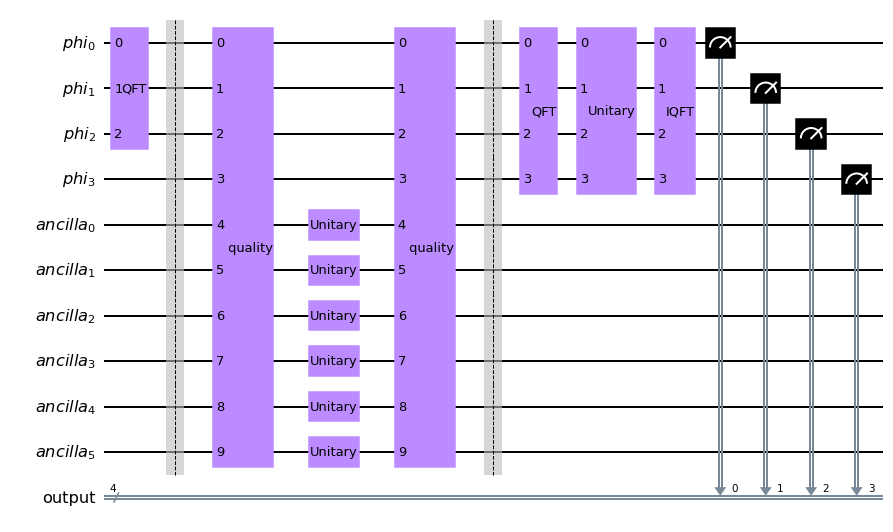

In [ ]:
# Visualise circuit
cct = create_circuit(**qwoaParameters([1,1], generate3RegGraph(4), [[1]], p=1)) # doesn't matter what the graph looks like if we just want to see the circuit
cct.draw('mpl')

In [71]:
p=4

approximation_ratio_qwoa = approximation_ratio_qaoa = 0
total = 0
connectivityList = [[3], [1], [4], [2]]
#connectivityList = [[1,2,4,8,16]] * p # [[1,10]] * p
#connectivityList = [[1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9],[1,2,3,4,5,6,7,8],[1,2,3,4,5,6,7],
#        [1,2,3,4,5,6],[1,2,3,4,5],[1,2,3,4],[1,2,3],[1,2],[1]][10-p:]
print(len(connectivityList))
print(connectivityList)
initialParametersList = [1]*2*p

#Check whether QWOA finds correct answer on 20 random 3-reg graphs
for x in range(20):
    graph = nx.gnp_random_graph(n=10, p = 0.7)
    graph = generate3RegGraph(6) #6 nodes
    qwoaExpectation = get_approximation_ratio(initialParametersList, graph, connectivityList, p, False)
    print("qwoa expectation:", qwoaExpectation)
    approximation_ratio_qwoa+=qwoaExpectation
    qaoaExpectation = get_approximation_ratio_qaoa(graph, p)
    print("qaoa expectation:", qaoaExpectation)
    approximation_ratio_qaoa+=qaoaExpectation
    total+=1
    #print(f"Successes: {successes}. total: {total}")
print("FINAL")
print(f"Approximation ratio for qwoa was {approximation_ratio_qwoa/total}")
print(f"Approximation ratio for qaoa was {approximation_ratio_qaoa/total}")
print()

# graph = generate3RegGraph(6) #6 nodes
# connectivityList = [[1,10]] * p
# initialParametersList = [1]*2*p
# parameters = qwoaParameters(initialParametersList, graph, connectivityList, p, False)
# #circuit = create_circuit(**parameters)
# #display(circuit.draw('mpl'))
# run_simulation(initialParametersList, graph, connectivityList, p)

4
[[3], [1], [4], [2]]


/tmp/ipykernel_25087/3143004126.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  eigenvaluesListOfLists.append(np.linalg.eig(nx.adjacency_matrix(solution_space_graph).todense())[0])


Optimisation resulting angles were [1.02076093 1.00638891 1.00351885 0.98028943 1.99314131 2.00530734
 0.99768146 1.98395553]
qwoa expectation: 0.7064732142857143
qaoa expectation: 0.8592354910714286
Optimisation resulting angles were [1.03271834 1.24937042 1.02069833 1.02269484 0.9763648  1.97370293
 0.98940853 0.84797781]
qwoa expectation: 0.7398158482142857
qaoa expectation: 0.7818080357142857
Optimisation resulting angles were [1.05296857 1.98288965 1.09606968 1.10007907 1.06169644 2.30360649
 1.05261532 1.10190464]
qwoa expectation: 0.7215401785714286
qaoa expectation: 0.8540736607142857
Optimisation resulting angles were [0.44895536 0.8134673  0.64214226 0.54793824 0.77758565 0.48179435
 0.89012574 0.98932711]
qwoa expectation: 0.6957310267857143
qaoa expectation: 0.8656529017857143
Optimisation resulting angles were [1.49552598 0.98899054 0.90022917 2.03905677 0.96432459 2.00795007
 0.94175997 0.99583121]
qwoa expectation: 0.7388392857142857
qaoa expectation: 0.8557477678571429


In [ ]:
def countour_plot (cost_function, resolution=32):
    grid_values = np.linspace(0, np.pi * 2, num=resolution)
    cost_values = np.zeros((resolution, resolution))
    row = column = 0
    for gamma in grid_values:
        for time in grid_values:
            cost_values[row][column] = cost_function([gamma, time])
            column += 1
        row += 1
        column = 0
    plt.figure(figsize=(15,15)) 
    plt.contourf(grid_values, grid_values, cost_values)
    plt.axis('scaled')
    plt.colorbar()
    plt.show()

In [ ]:


graph = generate3RegGraph(6) #6 nodes
countour_plot(qaoa.get_expectation(graph), 52)

In [ ]:
p=1
connectivityList = [range(1, 32)] * p # [[1,10]] * p
initialParametersList = [1]*2*p

parameters = qwoaParameters(initialParametersList, graph, connectivityList, p, False)

backend = Aer.get_backend('qasm_simulator')
backend.shots = 512

def execute_circ_for_contour(theta):
        parameters["params"] = theta
        qc = create_circuit(**parameters)
        test = transpile(qc, backend)
        qobj = assemble(test)
        counts = backend.run(qobj, seed_simulator=10, nshots=512).result().get_counts()
        return -compute_expectation(counts, graph)

countour_plot(execute_circ_for_contour, 32)

In [ ]:
# small_G = nx.Graph()
# small_G.add_nodes_from([0,1,2])
# small_G.add_edges_from([(0,1), (1,2)])
# nx.draw(small_G)

In [ ]:
# data = np.linalg.eig(
#     nx.adjacency_matrix(circulant_graph(8, [1,3])).todense()
# )
# eigenvalues = list(data[0])

# def execute_circ_small_graph(theta):
#     qc = create_circuit(theta, small_G, eigenvalues)
#     test = transpile(qc, backend)
#     qobj = assemble(test)
#     counts = backend.run(qobj, seed_simulator=10, nshots=512).result().get_counts()
#     return -compute_expectation(counts, small_G)

# countour_plot(execute_circ_small_graph, 52)